In [57]:
# библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



In [58]:
# считываем файлы

songs = pd.read_csv('songs.csv')
member = pd.read_csv('members.csv', parse_dates=[
                     'registration_init_time', 'expiration_date'])
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
extra_song = pd.read_csv('song_extra_info.csv')


In [59]:
# конвертируем всё в категории
def convert_obj_cat(df):
    obj_cols = df.select_dtypes(include='object').columns
    for col in obj_cols:
        df[col] = df[col].astype('category')

In [60]:
convert_obj_cat(train)
convert_obj_cat(test)
convert_obj_cat(songs)
convert_obj_cat(member)
convert_obj_cat(extra_song)

In [61]:
# соединяем все файлы в один
train = train.merge(songs, how='left', on='song_id')
test = test.merge(songs, how='left', on='song_id')
train = train.merge(member, how='left', on='msno')
test = test.merge(member, how='left', on='msno')
train = train.merge(extra_song, how='left', on='song_id')
test = test.merge(extra_song, how='left',on='song_id')

In [62]:
# Feature extractions
train['days_left'] = (train.expiration_date -
                      train.registration_init_time).dt.days.astype('int')
train['reg_year'] = train['registration_init_time'].dt.year
train['reg_month'] = train['registration_init_time'].dt.month
train['reg_date'] = train['registration_init_time'].dt.day

train['exp_year'] = train['expiration_date'].dt.year
train['exp_month'] = train['expiration_date'].dt.month
train['exp_date'] = train['expiration_date'].dt.day

In [63]:
# выкидываем колонки которые только что преобразовали удобнее
train.drop(columns=['registration_init_time',
                    'expiration_date'], index=1, inplace=True)

In [65]:
# получить год
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan


train['song_year'] = train['isrc'].apply(isrc_to_year)


train.drop(['isrc', 'name'], axis=1, inplace=True)

KeyError: 'isrc'

In [ ]:
# посчитать фичи
def gener_id_count(x):
    if pd.isnull(x):
        return x
    else:
        return x.count('|')+1


def lyricist_count(x):
    if pd.isnull(x):
        return x
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def composer_count(x):
    if pd.isnull(x):
        return x
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def artist_count(x):
    if pd.isnull(x):
        return x
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def is_featured(x):
    if 'feat' in str(x):
        return 1
    return 0

In [66]:
train['gener_count'] = train['genre_ids'].apply(gener_id_count)
train['lyricist_count'] = train['lyricist'].apply(
    lyricist_count)
train['composer_count'] = train['composer'].apply(
    composer_count)
train['artist_count'] = train['artist_name'].apply(
    artist_count)
train['features'] = train['artist_name'].apply(is_featured)

In [67]:
train['song_id']

0          BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=
2          JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=
3          2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=
4          3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=
5          3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=
                               ...                     
7377413    VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=
7377414    z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=
7377415    750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=
7377416    G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=
7377417    Ju0VGkjWeBUZCd7r5Az2hUImhMoWxWLUicOedsmvG0g=
Name: song_id, Length: 7377417, dtype: object

In [68]:

y_train = train['target']
x_train = train.drop(['target'], axis=1)
convert_obj_cat(x_train)

In [69]:
# преобразовываем в строки
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in x_train.columns:
    if x_train[column_name].dtype.name == 'category':
        x_train[column_name] = le.fit_transform(
            x_train[column_name].astype(str))
    else:
        pass

In [47]:
x_train = x_train.fillna(-1)

In [48]:
x_train.shape

(7377417, 28)

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.95)

In [50]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100, oob_score=False, n_jobs=-1)
rf.fit(X_train, Y_train)

RandomForestClassifier(n_jobs=-1)

In [51]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.663


In [52]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(Y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.66475769 0.66114193]
recall: [0.6477749 0.6778008]
fscore: [0.65615643 0.66936773]
support: [3480087 3528460]


Confusion matrix, without normalization
[[2254313 1225774]
 [1136867 2391593]]
Normalized confusion matrix
[[0.65 0.35]
 [0.32 0.68]]


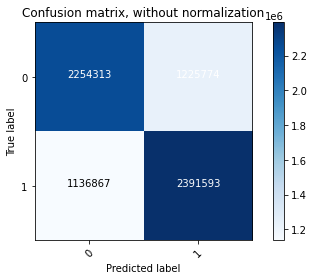

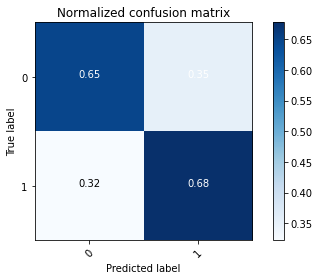

In [53]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['0', '1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [55]:

# Calculate ndcg score
from sklearn.metrics import ndcg_score
# This is where I get an error
ndcg_score([Y_test], [predicted], k=20)

0.6611419300281115